In [2]:
### Library Import Initialization

import numpy as np
import math
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm


In [3]:
### Function to Import Stock Tickers

def import_stock_data(tickers, start_date):
    data = pd.DataFrame()
    if len([tickers]) == 1:
        data[tickers] = yf.download(tickers, start_date)['Adj Close']
        data = pd.DataFrame(data)
    else:
        for t in tickers:
            data[t] = yf.download(tickers, start_date)['Adj Close']
    return data


## Black-Scholes Model

The Black-Scholes model is a mathematical model used to calculate the theoretical price (premium) of European-style options. The model provides a formula for estimating the fair market value of options based on certain key factors. Understanding how option premiums tie into the Black-Scholes model involves looking at the components of the formula and their impact on the option price.


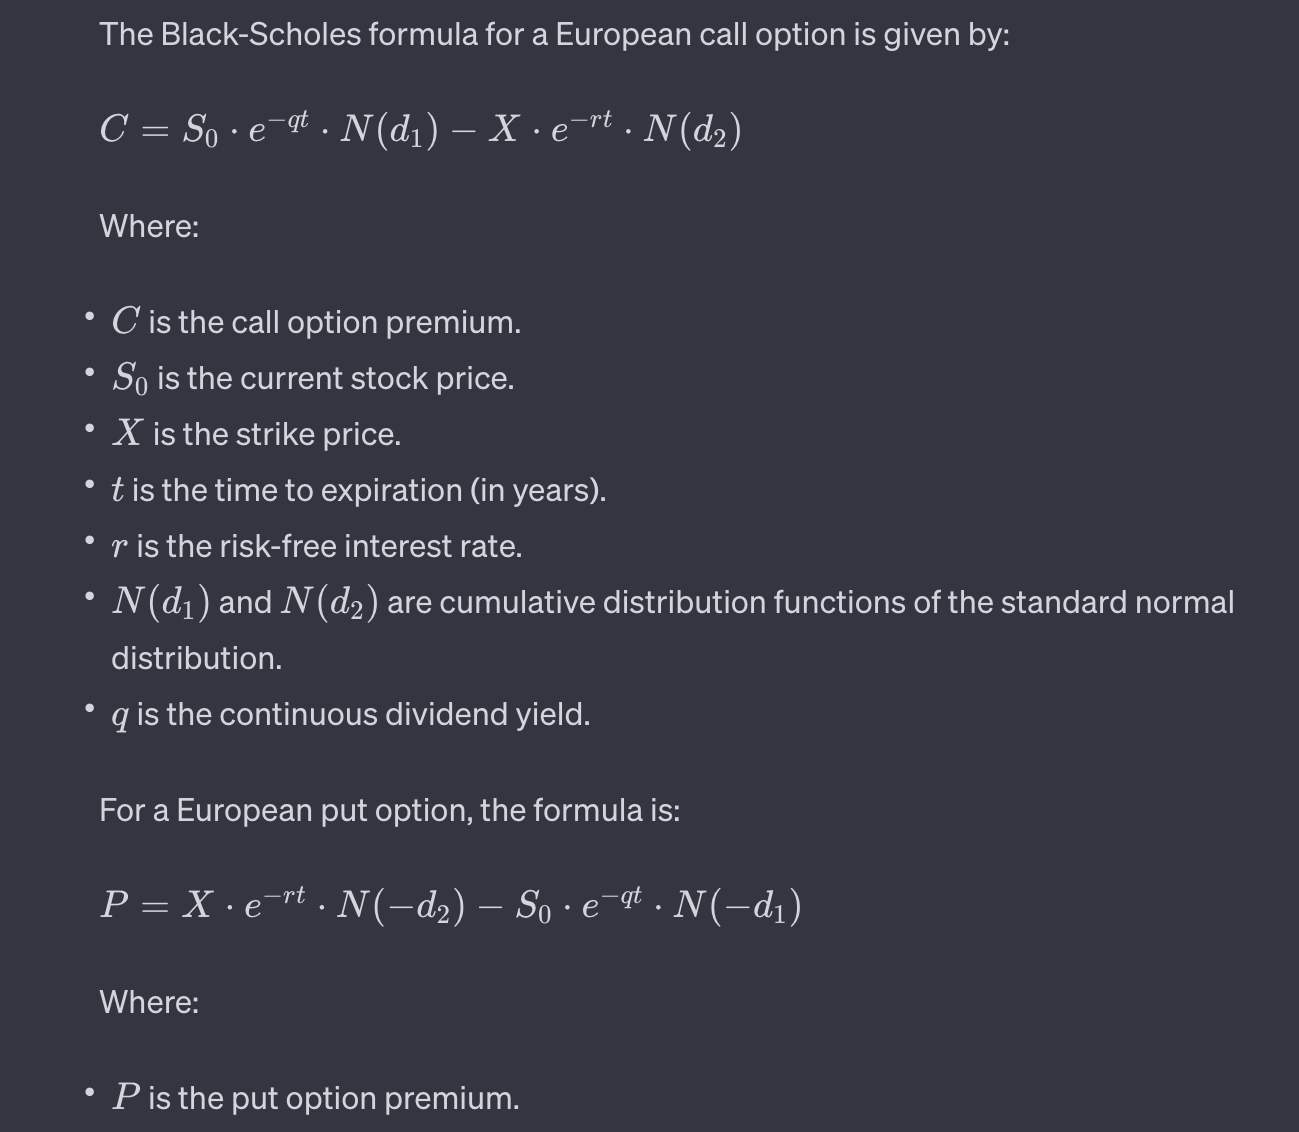

In [4]:

from IPython.display import Image
Image(filename='/Users/mburley/Downloads/BlackScholes.png', width = 600, height = 300)

In [5]:
### Multiple Stocks

tickers = ['GOOG', 'AAPL', 'GE', 'AMZN']
start_date = '2010-01-01'
stock_data = import_stock_data(tickers, start_date)
print(stock_data)

[*********************100%%**********************]  4 of 4 completed

                  GOOG        AAPL          GE        AMZN
Date                                                      
2010-01-04    6.470741    6.695000   67.992661   15.610239
2010-01-05    6.481928    6.734500   68.344711   15.541497
2010-01-06    6.378826    6.612500   67.992661   15.149715
2010-01-07    6.367032    6.500000   71.513321   14.797037
2010-01-08    6.409362    6.676000   73.053581   14.994298
...                ...         ...         ...         ...
2024-02-29  180.750000  176.759995  156.889999  139.779999
2024-03-01  179.660004  178.220001  158.649994  138.080002
2024-03-04  175.100006  177.580002  161.009995  134.199997
2024-03-05  170.119995  174.119995  157.860001  133.779999
2024-03-06  169.119995  173.509995  159.500000  132.559998

[3567 rows x 4 columns]


In [6]:
### Function to compute sigma (std dev of log normal historical stock return data)

def compute_sigma(returns):
    # Compute the standard deviation of returns
    sigma = np.std(returns) / 100
    return sigma

print(compute_sigma(stock_data))


GOOG    0.572128
AAPL    0.555564
GE      0.365289
AMZN    0.405514
dtype: float64


In [7]:
### Function to Get Stock Dividends

def get_dividends(tickers):
    divs = {}  # Use a dictionary to store dividends for each stock
    last_divs = {}  # Get Latest dividend for each stock
    for ticker in tickers:
        div_data = yf.Ticker(ticker).dividends
        divs[ticker] = div_data

    for ticker, div_data in divs.items():
        if len(div_data) > 0:
            last_divs[ticker] = div_data.iloc[-1]
        else:
            last_divs[ticker] = 0

    divs_df = pd.DataFrame.from_dict(last_divs, orient='index', columns=['Dividends'])
    divs_df.index.name = 'Tickers'
    divs_df.reset_index(inplace=True)
    print(divs_df)

    return divs_df

#divs = get_dividends(tickers)


In [8]:
### Function to return BS input values

strike_prices = [195, 175, 139, 151]

def get_inputs(stock_data, tickers, strike_prices):
    # Compute sigma values for each stock
    sigma = compute_sigma(stock_data)
    # Get most recent prices for each stock
    most_recent_price = stock_data.iloc[-1, 0:len(tickers)].astype(float)
    # Create a DataFrame from the lists
    input_df = pd.DataFrame({'Tickers': tickers, 'Market Price': most_recent_price, 'Sigma': sigma})
    # Merge Dividend Dataframe to update Result DataFrame
    input_df = input_df.merge(get_dividends(tickers), how = 'left', on = 'Tickers')
    # Add Strike Prices column to df
    input_df['Strike Price'] = strike_prices

    return input_df

inputs = get_inputs(stock_data, tickers, strike_prices)
#print(inputs)

  Tickers  Dividends
0    GOOG       0.00
1    AAPL       0.24
2      GE       0.08
3    AMZN       0.00


In [9]:
### Function to compute Black-Scholes

def BlackScholes(option_type, r, S_0, K, T, sigma, q):

    d_1 = (np.log(S_0 / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d_2 = d_1 - sigma * np.sqrt(T)

    ## Call Option
    if option_type == 0:
        option_price = S_0 * np.exp(-q * T) * norm.cdf(d_1) - K * np.exp(-r * T) * norm.cdf(d_2)
    ## Put Option
    elif option_type == 1:
        option_price = K * np.exp(-r * T) * norm.cdf(-d_2) - S_0 * np.exp(-q * T) * norm.cdf(-d_1)
    else:
        raise ValueError("Invalid option_type. Use 0 for call option or 1 for put option.")

    return option_price

In [10]:
### Final BS Calculation stored in DataFrame

# Define a function to apply the BlackScholes function to each row
def apply_black_scholes(df):
    # Extract variables from the row
    option_type_call = 0  # Assuming option_type is 0 for call options
    option_type_put = 1  # Assuming option_type is 1 for put options
    r = 0.05  # Assuming the risk-free rate of 5%
    S_0 = df['Market Price']
    K = df['Strike Price']
    T = 0.5  # Assuming time to expiration is 0.5 years
    sigma = df['Sigma']
    q = df['Dividends']  # Assuming q is the dividend yield

    # Call the BlackScholes function with extracted variables
    call_option_price = BlackScholes(option_type_call, r, S_0, K, T, sigma, q)
    put_option_price = BlackScholes(option_type_put, r, S_0, K, T, sigma, q)
    
    # Assign the option prices to new columns in the DataFrame
    df['Call Premium'] = call_option_price
    df['Put Premium'] = put_option_price
    
    return df

# Apply the function to each row of the DataFrame
result_df = inputs.apply(apply_black_scholes, axis = 1)

# Display the updated DataFrame with option prices
print(result_df[['Tickers', 'Market Price', 'Sigma', 'Dividends', 'Strike Price', 'Call Premium', 'Put Premium']])


  Tickers  Market Price     Sigma  Dividends  Strike Price  Call Premium  \
0    GOOG    169.119995  0.572128       0.00           195     19.451661   
1    AAPL    173.509995  0.555564       0.24           175     17.736796   
2      GE    159.500000  0.365289       0.08           139     25.306690   
3    AMZN    132.559998  0.405514       0.00           151      9.648935   

   Put Premium  
0    40.517099  
1    34.526471  
2     7.628852  
3    24.360734  


In [13]:
### Manual Test

S_0 = 40
K = 45
r = 0.03
q = 0
sigma = 0.4
option_type = 0
T = 0.3333

result = BlackScholes(option_type, r, S_0, K, T, sigma, q)
print(result)

2.0234313053558424
